# Future's league, 
### Team : Excellent in Analysis
#### 팀장 경북대학교 정재훈, 팀원 박준수 김민기 김동언 우지수

In [135]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from numpy.random import seed
from sklearn import model_selection
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import lightgbm
import datetime


## 전처리

* 전처리 과정의 대부분 Samsung Brightics Studio와 Excel을 이용하였습니다. 일부 Python을 이용한부분만 아래에 두겠습니다. 

데이터 불러오기

In [28]:
AFSNT = pd.read_csv('AFSNT.csv', engine = 'python')
AFSNT_DLY = pd.read_csv('AFSNT_DLY.csv', engine = 'python')

In [26]:
AFSNT_raw = AFSNT.copy()
AFSNT_DLY_raw = AFSNT_DLY.copy()

CNR 즉 결항은 주요관심사가 아니었기 떄문에 결항여부를 포함하고있는  
결항했던 데이터들은 모두 제거하고 결항에 관련된 열들을 제거 (CNL, CNR)

In [100]:
AFSNT.head()

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR
0,2017,1,1,일,ARP3,ARP6,J,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN
1,2017,1,1,일,ARP3,ARP6,J,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN
2,2017,1,1,일,ARP3,ARP6,J,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN
3,2017,1,1,일,ARP3,ARP6,J,J1957,SEw3NzE4,D,N,13:25,14:09,Y,C02,N,NaN
4,2017,1,1,일,ARP3,ARP6,J,J1958,SEw3NzE4,A,N,16:10,16:31,N,NaN,N,NaN


In [30]:
AFSNT = AFSNT[AFSNT['CNR'].isna() == True]

Test data의 정확한 예측 및 데이터의 경량화를 위해 Test data에 포함되어있는 항공사를  
포함하고있는 Train set만 추출

In [34]:
AFSNT = AFSNT[(AFSNT['FLO'] == 'A') | (AFSNT['FLO'] == 'B') | (AFSNT['FLO'] == 'F') |  (AFSNT['FLO'] == 'H') | (AFSNT['FLO'] == 'I') | (AFSNT['FLO'] == 'J') | (AFSNT['FLO'] == 'L') | (AFSNT['FLO'] == 'M')]

마찬가지의 이유로 9월 16일 ~ 9월 30일로 예정된 항공편들은 정기편에 해당하므로  
데이터에서 부정기편 데이터는 제거함.  
다만, 예외적으로 ARP10에 해당하는 공항은 모든 비행이 부정기편에 해당하므로 남기기로 결정  
그 후 IRR(정기편, 부정기편) 칼럼 제거

In [36]:
temp1 = AFSNT[AFSNT['ODP'] == 'ARP10']
temp2 = AFSNT[AFSNT['ARP'] == 'ARP10']
AFSNT = AFSNT[AFSNT['IRR'] == 'N']
temptemp = pd.concat([AFSNT,temp1,temp2], axis = 0)
temptemp.drop(columns='IRR', inplace =True)
#temptemp.to_csv('preprocessing.csv', encoding = 'utf-8')

위 preprocessing.csv file을 각 팀원들이 맡은 부분에따라 유의미한 feature를 생성 하였습니다.  
대부분 Samsung Brightics Studio를 사용하여 해당과정은 아래에 설명하겠습니다.  

---

## Features
> by Samsung Brights studio & Excel

#### 지연율 변수
* dlyrate_ARP  
전체데이터에서 출발 공항별로 '지연율'을 계산하여 변수화 하였습니다.  
* dlyrate_ODP  
전체데이터에서 도착 공항별로 '지연율'을 계산하여 변수화 하였습니다.
* dlyrate_FLO  
전체데이터에서 항공사별로 '지연율'을 계산하여 변수화 하였습니다.

#### SNA(Social Network Analysis)의 결과 변수
* degree  
공항 노드의 degree 수
* between  
공항 노드의 매개변수성
* edge  
공항 노드 사이 edge 수

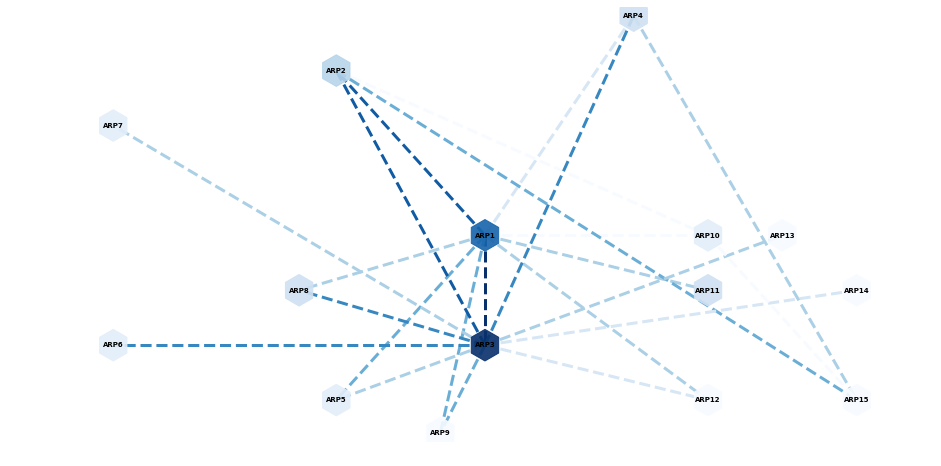

In [137]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def matrix_to_weight_network(matrix,ARP_list,node_weight): #matrix를 weight network로 변환
    G = nx.Graph()
    G.add_nodes_from([("ARP{}".format(i+1), {'weight': node_weight[i]}) for i in range(len(ARP_list))])
    for i in range(len(ARP_list)-1):
        for j in range(i + 1, len(ARP_list)):  
            if (matrix[i, j] != 0):
                G.add_edge(ARP_list[i], ARP_list[j],weight=matrix[i,j])  # weight 가 있는 네트워크로 간주
    return G
# Train 불러오기
train=pd.read_csv("Full_Data_EDA.csv", engine= 'python')

# 행렬 생성
ARP_list = ['ARP1','ARP2','ARP3','ARP4','ARP5','ARP6','ARP7','ARP8','ARP9','ARP10','ARP11','ARP12','ARP13','ARP14','ARP15']

ARP_matrix = np.zeros((len(ARP_list),len(ARP_list)))

for i in range(train.shape[0]):
    row = ARP_list.index(train['ARP'][i])
    col = ARP_list.index(train['ODP'][i])
    ARP_matrix[row,col] += 1

node_weight =[9,4,11,3,2,2,2,3,1,2,3,1,1,1,1] #degree 값으로 node_weight 주기
G = matrix_to_weight_network(ARP_matrix,ARP_list,node_weight)
#print(G.degree())
B = nx.betweenness_centrality(G)
#print(B)
edge_list = [(u, v) for (u, v, d) in G.edges(data=True)]
edge_weight=[6,7,2,4,3,4,1,3,3,6,1,4,5,3,5,3,5,4,2,3,2,3,1] # edge 값을 확인하여 임의로 weight 조정


plt.figure(figsize=(16, 8))
plt.margins(x=0.1, y=0.02)

pos = {'ARP1':[2, -1.5], 'ARP2':[1, 0], 'ARP3':[2, -2.5], 'ARP4':[3, 0.5],
       'ARP5':[1, -3], 'ARP6':[-0.5, -2.5], 'ARP7':[-0.5, -0.5],
       'ARP8':[0.75, -2], 'ARP9':[1.7, -3.3],
       'ARP10':[3.5, -1.5], 'ARP11':[3.5, -2.0], 'ARP12':[3.5, -3], 'ARP13':[4.0, -1.5], 'ARP14':[4.5, -2.0], 'ARP15':[4.5, -3]}

nx.draw_networkx_nodes(G, pos, node_color=node_weight, node_shape='h',node_size=1000, cmap=plt.cm.Blues, alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color=edge_weight,width=3, edge_cmap=plt.cm.Blues,style='dashed')
nx.draw_networkx_labels(G, pos, font_family='sans-serif', font_color='black', font_size=7, font_weight='bold')
plt.axis('off')
plt.show()




#### 날씨변수

* cloud_height  
운고
* visibility  
시정거리
* mean_temp  
평균온도  
* mean_sea  
평균 해수면 높이
* relative_humidity  
평균 습도
* max_temp  
최고 기온
* min_temp  
최저 기온
* mean_wind  
평균 풍속

#### 연결지연 관련 변수
* Accumulate  
항공사별로 하루에 같은 편도에 대해서 순서를 매김

#### 요일 일자 관련 변수 
연/월/요일/시간 변수 (One-hot encoding)

* SDT_YY_0~2  
2017~2019년 연도 변수

* SDT_MM_0~11  
1월 ~ 12월 월별 변수

* SDT_MM_0~6  
월요일~일요일 요일 변수

* STT 0 ~ 23  
00~24시 시간 변수

## Data set 설명
위 feature들을 통해 만들어낸 최종 데이터 세트가 보내드린 압축파일의 Final_Train입니다.  
저희 팀은 데이터를 다소 엄격하게 다루었습니다. 데이터 셋에 대한 설명은 아래와 같습니다
Test set에 M 항공사가 추가되어있었지만 저희는 항공사에 대해서 새로운 변수를 생성해냈기때문에 해당 칼럼을 포함한 데이터 / 포함하지않은 데이터를 나누었습니다 해당 데이터 각각 Final_Train / Final_Train_M 입니다.  
Tunnig - valid set으로 parameter Tuning을 진행하였고 이를 Train - test set에다가 적용하였습니다.  
최종모델은 Full_data를 해당 hyper parameters로 학습 시키기로 했습니다.  
모델의 일반화된 성능을 추정하고 알고리즘의 성능을 높이기 위해 3-way hold out 방법을 사용하였습니다.  
먼저 Final_Train을 8:2의 비율로 랜덤샘플링하여 Train 파일과 Test 파일로 분리하였습니다. Train 파일을 다시 8:2의 비율로 랜덤샘플링하여 tuning 파일과 valid 파일로 분리하였습니다. 새로운 변수 중 Train set이 어떻게 바뀌느냐에 따라 값의 변동이 있는 변수가 존재하였기 때문에 튜닝 단계나 일반화된 성능 추정 단계에서 Test 파일이나 Valid 파일의 과적합을 방지하기 위해 tuning, Train 파일에서 각각 새로운 변수를 생성하였습니다. tuning 단계에서 프로젝트에 사용하는 알고리즘을 valid set을 통해 성능을 평가하여 최적화된 알고리즘과 Parameter를 선택하여, Train 파일로 Retrain 시킵니다.  
test 파일로 일반화된 성능을 평가한 후, 최종적으로 FInal_train 파일을 통해 train 시킨 모델로 9/16 ~ 9/30의 지연율을 예측합니다.

### Covariate-Shift check

```python
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#불러오기
Shift_train = pd.read_csv("Shift_train.csv")
Shift_test = pd.read_csv("Shift_test.csv")

train_x = Shift_train.drop(['DLY','find'],axis=1)
train_y = Shift_train.find

test_x = Shift_test.drop(['DLY','find'],axis=1)
test_y = Shift_test.find

Shift_train_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=3, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=429,
              reg_alpha=1,reg_lambda=0, scale_pos_weight=1, seed=429,
              silent=None, subsample=1, verbosity=2, eval_metric='auc')

Shift_train_model.fit(train_x,train_y,early_stopping_rounds=25, eval_set=[(test_x,test_y)],eval_metric='auc')


pred_proba = Shift_train_model.predict_proba(test_x)[:,1]
auc = roc_auc_score(test_y, pred_proba)
print("AUC on test set  : ", auc)
```

### Feature selection

Tree 기반의 LightGBM 알고리즘의 Feature importance (split, gain)을 참고하여 변수선택의
forward / backward 를 통해 Holiday 변수들과 일부 날씨변수들을 제거하기로 하였습니다.  
그래서 저희가 최종적으로 보내드릴 데이터셋은 해당변수가 제거되어있습니다.









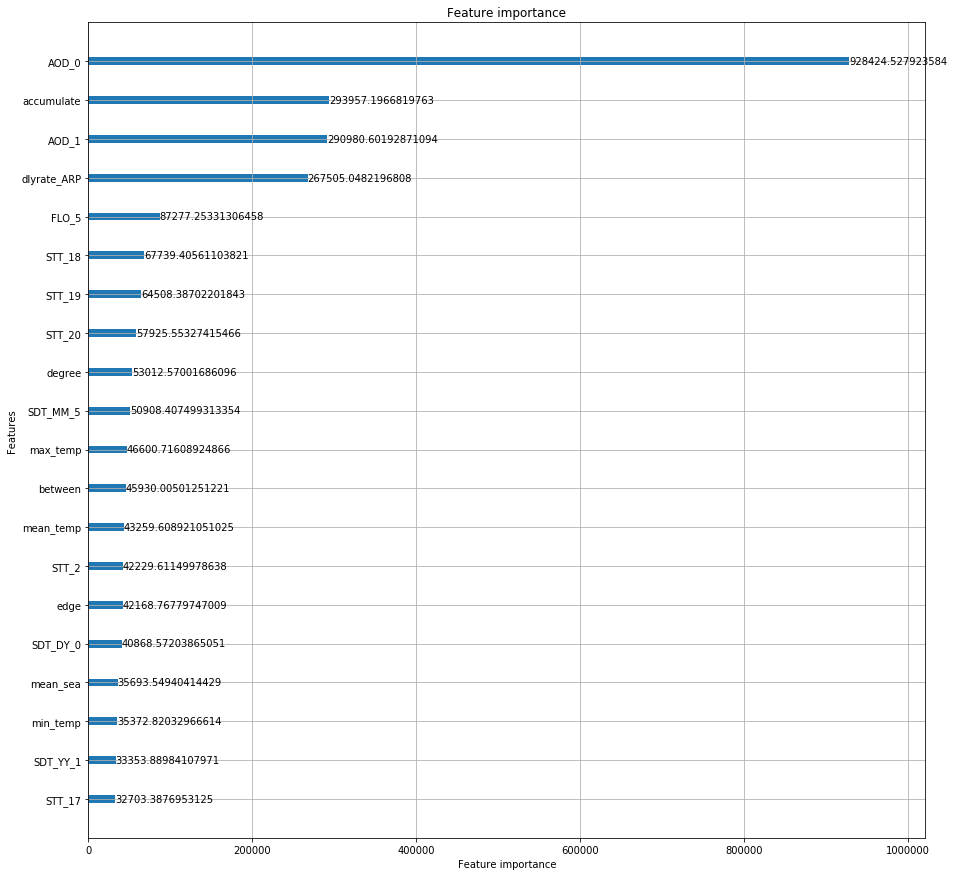

In [161]:
lightgbm.plot_importance(gbm, figsize = (15,15), max_num_features=20, importance_type = 'gain')

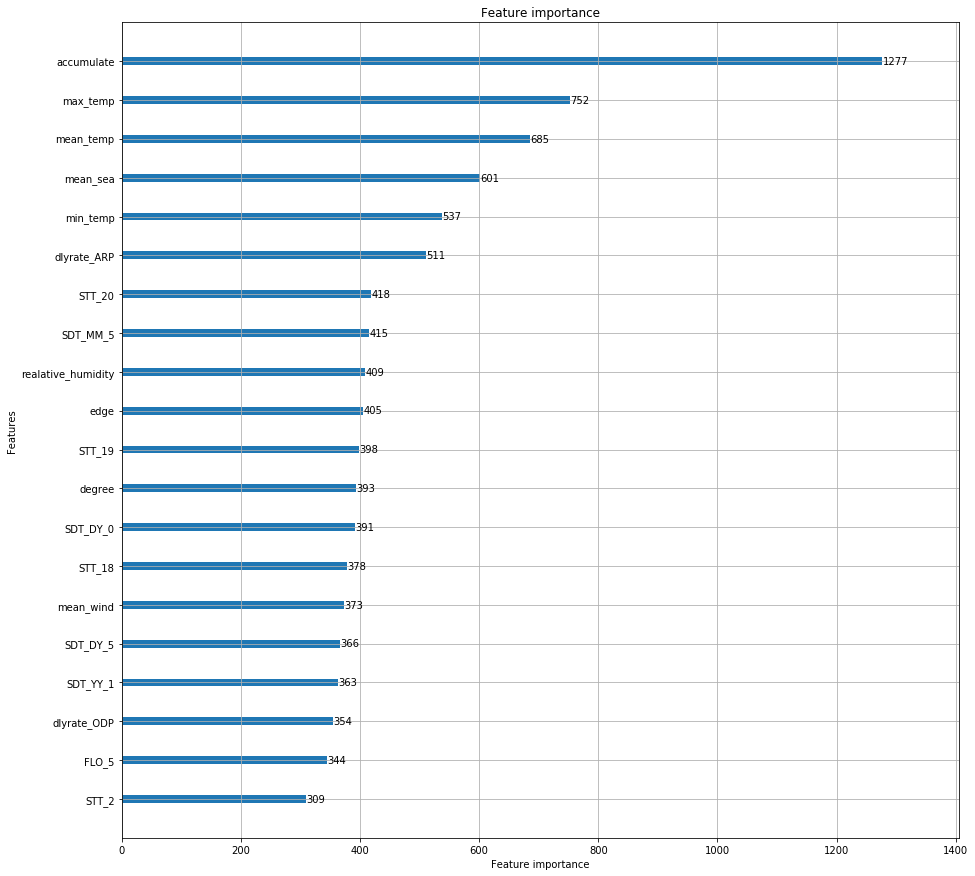

In [159]:
lightgbm.plot_importance(gbm, figsize = (15,15), max_num_features=20,importance_type=)

## Modeling

기본적인 Machine learning 알고리즘부터 비교적 최신 기법인 XGBoost, LightGBM, 
또, FCNN / RNN 을 사용하여 각 알고리즘의 최대성능을 뽑아내고, 성능(AUROC기준)이 가장 좋았던 알고리즘인 LightGBM을 최종 모델로 선택하였습니다.
  

In [171]:
Tuning = pd.read_csv('tunning.csv', engine = 'python')
Valid = pd.read_csv('valid.csv', engine = 'python')
Test = pd.read_csv('test.csv', engine = 'python')
Train = pd.read_csv('train.csv', engine = 'python')
Final_test = pd.read_csv('Final_Test.csv', engine = 'python')
Final_train= pd.read_csv('Final_Train.csv', engine = 'python')

In [40]:
Valid.head()

,dlyrate_ODP,dlyrate_ARP,DLY,holiday_1,holiday_2,holiday_3,holiday_4,cloud_height,Visibility,RVR,...,STT_18,STT_19,STT_20,accumulate,SDT_YY_0,SDT_YY_1,SDT_YY_2,degree,between,edge
0,0.119,0.119,0,0,0,0,1,1.0,0.441,0.000,...,0,0,0,7,0,1,0,13,0.604,0.13
1,0.119,0.119,0,0,0,0,1,1.0,0.146,0.700,...,0,0,0,6,1,0,0,13,0.604,0.13
2,0.119,0.119,0,1,0,0,0,1.0,0.457,0.000,...,0,0,0,3,1,0,0,13,0.604,0.13
3,0.119,0.119,1,1,0,0,0,1.0,0.229,0.804,...,0,1,0,2,0,1,0,13,0.604,0.13
4,0.119,0.119,0,1,0,0,0,1.0,0.146,0.700,...,0,0,1,2,1,0,0,13,0.604,0.13


몇몇 알고리즘들은 실행에 시간이 너무 오래 걸리므로 Markdown 형식으로 코드와 결과만 첨부하겠습니다.  
다만, 최종모델인 LightGBM은 결과창까지 조회하실 수 있도록 하겠습니다

### XGBoost

```python
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score

#불러오기
tuning_DF = pd.read_csv("tunning.csv")
valid_DF = pd.read_csv("valid.csv")


tuning_x = tuning_DF.drop(['DLY'],axis=1)
tuning_y = tuning_DF.DLY

valid_x = valid_DF.drop(['DLY'],axis=1)
valid_y = valid_DF.DLY

tuning_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=300, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=429,
              reg_alpha=1,reg_lambda=0, scale_pos_weight=1, seed=429,
              silent=None, subsample=1, verbosity=2, eval_metric='auc')

tuning_model.fit(tuning_x,tuning_y,early_stopping_rounds=25, eval_set=[(valid_x,valid_y)],eval_metric='auc')

pred_proba = tuning_model.predict_proba(tuning_x)[:,1]
auc = roc_auc_score(tuning_y, pred_proba)
print("AUC on tuning_train set  : ", auc)

pred_proba = tuning_model.predict_proba(valid_x)[:,1]
auc = roc_auc_score(valid_y, pred_proba)
print("AUC on valid set  : ", auc)
```

#### tuning - valid  set by XGBoost
Training AUC : 0.793  
Test AUC : 0.786

### Logistic

```python
from sklearn.linear_model import LogisticRegression
X_traindata = Tuning.drop('DLY',axis=1)
X_validdata = Valid.drop('DLY',axis=1)

Y_traindata = Tuning['DLY']
Y_validdata = Valid['DLY']

parameters = {'C':[0.1,1,10,100]}
logreg = LogisticRegression(random_state=429,penalty= 'l1')
clf = GridSearchCV(logreg,parameters,cv=2)
history = clf.fit(X_traindata,Y_traindata)
Y_validpred = history.predict_proba(X_validdata)[:,1]
vfpr , vtpr , vthreshold = roc_curve(Y_validdata,Y_validpred)
vAUC = roc_auc_score(Y_validdata,Y_validpred)
Y_trainpred = history.predict_proba(X_traindata)[:,1]
tfpr , ttpr , tthreshold = roc_curve(Y_traindata,Y_trainpred)
tAUC = roc_auc_score(Y_traindata,Y_trainpred)
plt.plot(tfpr,ttpr,'o-')
plt.plot(vfpr, vtpr, 'o-')
print(tAUC)
print(vAUC)
```

#### tuning - valid  set by Logistic Classifier
Training AUC : 0.7109  
Test AUC : 0.7113

### Adaboost

```python
from sklearn.ensemble import AdaBoostClassifier
parameters = {'n_estimators':[500,100,1500,2000],'learning_rate':[0.001,0.05,0.01]}
Ada = AdaBoostClassifier(random_state=429,n_estimators=1)
clf = GridSearchCV(Ada,parameters,cv=5)
history = clf.fit(X_traindata,Y_traindata)

Y_validpred = clf.predict_proba(X_validdata)[:, 1]
vfpr, vtpr, vthreshold = roc_curve(Y_validdata, Y_validpred)
vAUC = roc_auc_score(Y_validdata, Y_validpred)
Y_trainpred = Ada.predict_proba(X_traindata)[:, 1]
tfpr, ttpr, tthreshold = roc_curve(Y_traindata, Y_trainpred)
tAUC = roc_auc_score(Y_traindata, Y_trainpred)
plt.plot(tfpr, ttpr, 'o-')
plt.plot(vfpr, vtpr, 'o-')
print(tAUC)
print(vAUC)
plt.show()
```

#### tuning - valid  set by AdaBoost
Training AUC : 0.7319  
Test AUC : 0.7288

### DNN

```python
import tensorflow as tf
from tensorflow import set_random_seed
from keras import models, layers
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers
import matplotlib.pyplot as plt
Nh_l = [512,512,512,512,512,512,512,512,512,512,512,512,512,512,512]
Nout = 2
Adam = optimizers.Adam(lr=0.001)

def plot_loss(history) :
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'],loc=0)


def plot_acc(history) :
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model acc')
    plt.ylabel('acc')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'],loc=0)
    
def create_network():
    # Start neural network
    network = models.Sequential()
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(Nh_l[0], activation='relu', input_shape=(Nin,), kernel_initializer='he_normal'))

    network.add(layers.Dropout(rate=0.2))
    network.add(layers.BatchNormalization())
    network.add(layers.Dense(Nh_l[1], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.Dense(Nh_l[2], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.Dropout(rate=0.2))
    network.add(layers.Dense(Nh_l[3], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.BatchNormalization())
    network.add(layers.Dense(Nh_l[4], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.Dropout(rate=0.2))
    network.add(layers.Dense(Nh_l[5], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.Dropout(rate=0.2))
    network.add(layers.Dense(Nh_l[6], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.Dropout(rate=0.2))
    network.add(layers.BatchNormalization())
    network.add(layers.Dense(Nh_l[7], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.Dropout(rate=0.2))
    network.add(layers.Dense(Nh_l[8], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.Dropout(rate=0.2))
    network.add(layers.Dense(Nh_l[9], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.Dropout(rate=0.2))
    network.add(layers.BatchNormalization())
    network.add(layers.Dense(Nh_l[10], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.Dropout(rate=0.2))
    network.add(layers.Dense(Nh_l[11], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.Dropout(rate=0.2))
    network.add(layers.BatchNormalization())
    network.add(layers.Dense(Nh_l[12], kernel_initializer='he_normal'))
    network.add(layers.LeakyReLU(alpha=0.1))
    network.add(layers.Dropout(rate=0.2))


    network.add(layers.Dense(Nout))
    network.add(layers.Activation('softmax'))

    # Compile neural network
    network.compile(loss='categorical_crossentropy',optimizer=Adam,metrics=['accuracy'])  # Root Mean Square Propagation
    # Return compiled network
    return network
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=1,verbose=0)
neural_network = KerasClassifier(build_fn=create_network, batch_size=512 ,epochs=50,validation_split=0.12, verbose=1,callbacks=[early_stopping])

#reg = GridSearchCV(neural_network,parameters,cv=kfold)


Nin = X_traindata.shape[1]

history = neural_network.fit(X_traindata,Y_traindata)

Y_validpred = neural_network.predict_proba(X_validdata)[:,1]
vfpr , vtpr , vthreshold = roc_curve(Y_validdata,Y_validpred)
vAUC = roc_auc_score(Y_validdata,Y_validpred)
Y_trainpred = neural_network.predict_proba(X_traindata)[:,1]
tfpr , ttpr , tthreshold = roc_curve(Y_traindata,Y_trainpred)
tAUC = roc_auc_score(Y_traindata,Y_trainpred)
plt.plot(tfpr,ttpr,'o-')
plt.plot(vfpr, vtpr, 'o-')
print(tAUC)
print(vAUC)
```

#### tuning - valid  set by Deep Neural Network
Training AUC : 0.7442  
Test AUC : 0.7410

### RNN

```python
X_train = X_traindata.values
X_test = X_validdata.values
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

from keras.layers import LSTM , Dense , Dropout

def create_network():
    model = models.Sequential()
    model.add(LSTM(150, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.BatchNormalization())
    model.add(Dense(2))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=0)
neural_network = KerasClassifier(build_fn=create_network, batch_size=512 ,epochs=50,validation_split=0.12, verbose=1,callbacks=[early_stopping])

history = neural_network.fit(X_train,Y_traindata)
Y_validpred = neural_network.predict_proba(X_test)[:,1]
vfpr , vtpr , vthreshold = roc_curve(Y_validdata,Y_validpred)
vAUC = roc_auc_score(Y_validdata,Y_validpred)
Y_trainpred = neural_network.predict_proba(X_train)[:,1]
tfpr , ttpr , tthreshold = roc_curve(Y_traindata,Y_trainpred)
tAUC = roc_auc_score(Y_traindata,Y_trainpred)
plt.plot(tfpr,ttpr,'o-')
plt.plot(vfpr, vtpr, 'o-')
print(tAUC)
print(vAUC)
```

#### tuning - valid  set by Recurrent Neural Network
Training AUC : 0.5430  
Test AUC : 0.5444

---
---

## 최종 Modeling
### LightGBM

모델링의 첫번째는 Tuning, Validation set을 통한 hyper-parameter tuning task 입니다.

In [87]:
X_train = Tuning.drop(['DLY'], axis = 1)
y_train =  Tuning['DLY']
X_test = Valid.drop(['DLY'], axis = 1)
y_test =  Valid['DLY']

In [90]:
seed(419)
gbm = lightgbm.LGBMClassifier( num_leaves=45
                              ,learning_rate = 0.15
                              , n_estimators = 2000
                              , max_depth=16
                              , boosting = 'goss'
                              , metric = 'auc'
                              ,lambda_l1 = 30
                              ,lambda_l2 = 20
                              ,min_gain_to_split = 4
                              ,min_child_weight = 4
	                            ,colsample_bytree=0.8
                              ,subsample=0.8
                              ,random_state = 419
                              )


gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds = 100)

[1]	valid_0's auc: 0.698578	valid_0's rmse: 0.328608
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.705931	valid_0's rmse: 0.326571
[3]	valid_0's auc: 0.708389	valid_0's rmse: 0.324922
[4]	valid_0's auc: 0.712295	valid_0's rmse: 0.323636
[5]	valid_0's auc: 0.713534	valid_0's rmse: 0.322685
[6]	valid_0's auc: 0.714506	valid_0's rmse: 0.321965
[7]	valid_0's auc: 0.71699	valid_0's rmse: 0.321334
[8]	valid_0's auc: 0.718479	valid_0's rmse: 0.320782
[9]	valid_0's auc: 0.719453	valid_0's rmse: 0.32033
[10]	valid_0's auc: 0.720623	valid_0's rmse: 0.319943
[11]	valid_0's auc: 0.722329	valid_0's rmse: 0.319562
[12]	valid_0's auc: 0.723417	valid_0's rmse: 0.319299
[13]	valid_0's auc: 0.72495	valid_0's rmse: 0.318991
[14]	valid_0's auc: 0.72576	valid_0's rmse: 0.31879
[15]	valid_0's auc: 0.726912	valid_0's rmse: 0.318515
[16]	valid_0's auc: 0.727798	valid_0's rmse: 0.318322
[17]	valid_0's auc: 0.729666	valid_0's rmse: 0.318012
[18]	valid_0's auc: 0.731341	vali

[153]	valid_0's auc: 0.784405	valid_0's rmse: 0.307576
[154]	valid_0's auc: 0.784436	valid_0's rmse: 0.307565
[155]	valid_0's auc: 0.784467	valid_0's rmse: 0.307556
[156]	valid_0's auc: 0.784632	valid_0's rmse: 0.307509
[157]	valid_0's auc: 0.784711	valid_0's rmse: 0.307487
[158]	valid_0's auc: 0.784738	valid_0's rmse: 0.307478
[159]	valid_0's auc: 0.784789	valid_0's rmse: 0.307467
[160]	valid_0's auc: 0.784938	valid_0's rmse: 0.307429
[161]	valid_0's auc: 0.785	valid_0's rmse: 0.307412
[162]	valid_0's auc: 0.78498	valid_0's rmse: 0.30741
[163]	valid_0's auc: 0.785002	valid_0's rmse: 0.307409
[164]	valid_0's auc: 0.785213	valid_0's rmse: 0.307378
[165]	valid_0's auc: 0.785213	valid_0's rmse: 0.307373
[166]	valid_0's auc: 0.785372	valid_0's rmse: 0.307338
[167]	valid_0's auc: 0.785358	valid_0's rmse: 0.307337
[168]	valid_0's auc: 0.78538	valid_0's rmse: 0.307331
[169]	valid_0's auc: 0.785386	valid_0's rmse: 0.307334
[170]	valid_0's auc: 0.785536	valid_0's rmse: 0.307308
[171]	valid_0's 

[304]	valid_0's auc: 0.790992	valid_0's rmse: 0.306021
[305]	valid_0's auc: 0.790959	valid_0's rmse: 0.306025
[306]	valid_0's auc: 0.790959	valid_0's rmse: 0.306023
[307]	valid_0's auc: 0.790982	valid_0's rmse: 0.306019
[308]	valid_0's auc: 0.79098	valid_0's rmse: 0.306023
[309]	valid_0's auc: 0.791009	valid_0's rmse: 0.306015
[310]	valid_0's auc: 0.791175	valid_0's rmse: 0.305985
[311]	valid_0's auc: 0.791177	valid_0's rmse: 0.305982
[312]	valid_0's auc: 0.791177	valid_0's rmse: 0.30598
[313]	valid_0's auc: 0.791188	valid_0's rmse: 0.305976
[314]	valid_0's auc: 0.791184	valid_0's rmse: 0.305977
[315]	valid_0's auc: 0.791189	valid_0's rmse: 0.305977
[316]	valid_0's auc: 0.791206	valid_0's rmse: 0.305969
[317]	valid_0's auc: 0.791215	valid_0's rmse: 0.305967
[318]	valid_0's auc: 0.791199	valid_0's rmse: 0.30597
[319]	valid_0's auc: 0.791242	valid_0's rmse: 0.305962
[320]	valid_0's auc: 0.791236	valid_0's rmse: 0.305963
[321]	valid_0's auc: 0.79124	valid_0's rmse: 0.30596
[322]	valid_0's

[456]	valid_0's auc: 0.793132	valid_0's rmse: 0.305482
[457]	valid_0's auc: 0.793159	valid_0's rmse: 0.305476
[458]	valid_0's auc: 0.793153	valid_0's rmse: 0.305473
[459]	valid_0's auc: 0.793155	valid_0's rmse: 0.305474
[460]	valid_0's auc: 0.793156	valid_0's rmse: 0.305475
[461]	valid_0's auc: 0.793158	valid_0's rmse: 0.305475
[462]	valid_0's auc: 0.793152	valid_0's rmse: 0.305473
[463]	valid_0's auc: 0.793172	valid_0's rmse: 0.305473
[464]	valid_0's auc: 0.793166	valid_0's rmse: 0.305471
[465]	valid_0's auc: 0.793173	valid_0's rmse: 0.305474
[466]	valid_0's auc: 0.793173	valid_0's rmse: 0.305469
[467]	valid_0's auc: 0.793176	valid_0's rmse: 0.305467
[468]	valid_0's auc: 0.793196	valid_0's rmse: 0.305459
[469]	valid_0's auc: 0.793233	valid_0's rmse: 0.305455
[470]	valid_0's auc: 0.79323	valid_0's rmse: 0.305455
[471]	valid_0's auc: 0.793252	valid_0's rmse: 0.305454
[472]	valid_0's auc: 0.793374	valid_0's rmse: 0.305422
[473]	valid_0's auc: 0.793392	valid_0's rmse: 0.305418
[474]	valid

[606]	valid_0's auc: 0.794965	valid_0's rmse: 0.30501
[607]	valid_0's auc: 0.794954	valid_0's rmse: 0.305013
[608]	valid_0's auc: 0.794937	valid_0's rmse: 0.305015
[609]	valid_0's auc: 0.794932	valid_0's rmse: 0.305015
[610]	valid_0's auc: 0.794944	valid_0's rmse: 0.305011
[611]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[612]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[613]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[614]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[615]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[616]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[617]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[618]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[619]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[620]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[621]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[622]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[623]	valid_0's auc: 0.794942	valid_0's rmse: 0.305011
[624]	valid

LGBMClassifier(boosting='goss', boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.8, importance_type='split', lambda_l1=30,
        lambda_l2=20, learning_rate=0.15, max_depth=16, metric='auc',
        min_child_samples=20, min_child_weight=4, min_gain_to_split=4,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=45,
        objective=None, random_state=419, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

In [91]:
y_pred1 = gbm.predict_proba(X_train, num_iteration = gbm.best_iteration_)
roc_auc_score(y_train, y_pred1[:,1])
y_pred2 = gbm.predict_proba(X_test, num_iteration = gbm.best_iteration_)
roc_auc_score(y_test, y_pred2[:,1])

print('Train AUROC = {}\nTest AUROC = {}'.format(round(roc_auc_score(y_train, y_pred1[:,1]), 3 ), round(roc_auc_score(y_test, y_pred2[:,1]),3)))

Train AUROC = 0.808
Test AUROC = 0.795


In [113]:
seed(1102)
gbm = lightgbm.LGBMClassifier( num_leaves=50
                              ,learning_rate = 0.01
                              , n_estimators = 300
                              , max_depth=18
                              , boosting = 'goss'
                              , metric = 'auc'
                              ,lambda_l1 = 30
                              ,lambda_l2 = 30
                              ,min_gain_to_split = 6
                              ,min_child_weight = 6
                                ,colsample_bytree=0.8
                              ,subsample=0.8
                              ,random_state = 419
                              )



gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds = 100)

[1]	valid_0's auc: 0.700152	valid_0's rmse: 0.331229
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.702466	valid_0's rmse: 0.331039
[3]	valid_0's auc: 0.704819	valid_0's rmse: 0.330848
[4]	valid_0's auc: 0.704666	valid_0's rmse: 0.330664
[5]	valid_0's auc: 0.707242	valid_0's rmse: 0.33048
[6]	valid_0's auc: 0.707725	valid_0's rmse: 0.330297
[7]	valid_0's auc: 0.708313	valid_0's rmse: 0.330121
[8]	valid_0's auc: 0.708107	valid_0's rmse: 0.329948
[9]	valid_0's auc: 0.710209	valid_0's rmse: 0.329776
[10]	valid_0's auc: 0.709895	valid_0's rmse: 0.329613
[11]	valid_0's auc: 0.710067	valid_0's rmse: 0.329443
[12]	valid_0's auc: 0.71117	valid_0's rmse: 0.329281
[13]	valid_0's auc: 0.712143	valid_0's rmse: 0.329198
[14]	valid_0's auc: 0.712029	valid_0's rmse: 0.329036
[15]	valid_0's auc: 0.711891	valid_0's rmse: 0.328881
[16]	valid_0's auc: 0.712076	valid_0's rmse: 0.328728
[17]	valid_0's auc: 0.71196	valid_0's rmse: 0.328574
[18]	valid_0's auc: 0.71215	val

[151]	valid_0's auc: 0.72445	valid_0's rmse: 0.319867
[152]	valid_0's auc: 0.724504	valid_0's rmse: 0.319842
[153]	valid_0's auc: 0.72457	valid_0's rmse: 0.319814
[154]	valid_0's auc: 0.724619	valid_0's rmse: 0.319791
[155]	valid_0's auc: 0.724707	valid_0's rmse: 0.319766
[156]	valid_0's auc: 0.724756	valid_0's rmse: 0.319743
[157]	valid_0's auc: 0.72487	valid_0's rmse: 0.319716
[158]	valid_0's auc: 0.724965	valid_0's rmse: 0.319689
[159]	valid_0's auc: 0.725051	valid_0's rmse: 0.319663
[160]	valid_0's auc: 0.725333	valid_0's rmse: 0.319628
[161]	valid_0's auc: 0.725426	valid_0's rmse: 0.319602
[162]	valid_0's auc: 0.725478	valid_0's rmse: 0.319577
[163]	valid_0's auc: 0.72557	valid_0's rmse: 0.31955
[164]	valid_0's auc: 0.725689	valid_0's rmse: 0.319522
[165]	valid_0's auc: 0.725736	valid_0's rmse: 0.319497
[166]	valid_0's auc: 0.725827	valid_0's rmse: 0.319475
[167]	valid_0's auc: 0.725885	valid_0's rmse: 0.319451
[168]	valid_0's auc: 0.725935	valid_0's rmse: 0.319427
[169]	valid_0's

LGBMClassifier(boosting='goss', boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.8, importance_type='split', lambda_l1=30,
        lambda_l2=30, learning_rate=0.01, max_depth=18, metric='auc',
        min_child_samples=20, min_child_weight=6, min_gain_to_split=6,
        min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=50,
        objective=None, random_state=419, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

In [99]:
y_pred1 = gbm.predict_proba(X_train, num_iteration = gbm.best_iteration_)
roc_auc_score(y_train, y_pred1[:,1])
y_pred2 = gbm.predict_proba(X_test, num_iteration = gbm.best_iteration_)
roc_auc_score(y_test, y_pred2[:,1])

print('Train AUROC = {}\nTest AUROC = {}'.format(round(roc_auc_score(y_train, y_pred1[:,1]), 3 ), round(roc_auc_score(y_test, y_pred2[:,1]),3)))

Train AUROC = 0.81
Test AUROC = 0.796


큼지막한 hyper-parameter tuning은 직접 했고 섬세한 파라미터 수정은 sklearn의 Gridsearch를 이용했습니다.  

num_leaves, learning_rate, n_estimators, max_depth등을 이용하여 데이터를 적합 시켜 AUC를 높이고자했고  
labmda, min_gain_to_split, min_child_weight 등의 parmeter를 이용하여 과적합을 막고자 하였습니다.

해당 모든과정은 너무 많고 복잡하여 굳이 모든과정을 넣지는 않겠습니다.  
다만 아래와같은 sklearn.model_seletion.GridserachCV로 세세한 parameter들을 결정하였습니다.

```python
parameters = { 'num_leaves':[55,60,65] , 'learning_rate' : [0.005,0.015,0.025,0.035] , 'max_depth' : [15,16,17,18]}
## num_leaves :  55 ~ 65
## learning_rate : 0.005 ~ 0.035
clf = GridSearchCV(estimator=gbm,param_grid=parameters)
clf.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'rmse', early_stopping_rounds = 100)
```

### Train-Test

In [197]:
Train_1 = pd.read_csv('train_1.csv', engine= 'python')
Test_1 = pd.read_csv('test_1.csv', engine= 'python')

In [200]:
X_train = Train.drop(['DLY'], axis = 1)
y_train = Train['DLY']
X_test = Test.drop(['DLY'], axis = 1)
y_test =  Test['DLY']

In [201]:
seed(1102)
gbm = lightgbm.LGBMClassifier( num_leaves=50
                              ,learning_rate = 0.01
                              , n_estimators = 300
                              , max_depth=18
                              , boosting = 'goss'
                              , metric = 'auc'
                              ,lambda_l1 = 30
                              ,lambda_l2 = 30
                              ,min_gain_to_split = 6
                              ,min_child_weight = 6
                                ,colsample_bytree=0.8
                              ,subsample=0.8
                              ,random_state = 419
                              )


gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds = 100)

[1]	valid_0's auc: 0.706629	valid_0's rmse: 0.287942
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.707444	valid_0's rmse: 0.287868
[3]	valid_0's auc: 0.716587	valid_0's rmse: 0.287693
[4]	valid_0's auc: 0.718838	valid_0's rmse: 0.287526
[5]	valid_0's auc: 0.718679	valid_0's rmse: 0.287377
[6]	valid_0's auc: 0.719204	valid_0's rmse: 0.287218
[7]	valid_0's auc: 0.721152	valid_0's rmse: 0.287048
[8]	valid_0's auc: 0.722199	valid_0's rmse: 0.286884
[9]	valid_0's auc: 0.721469	valid_0's rmse: 0.286764
[10]	valid_0's auc: 0.722391	valid_0's rmse: 0.286599
[11]	valid_0's auc: 0.722247	valid_0's rmse: 0.286453
[12]	valid_0's auc: 0.722416	valid_0's rmse: 0.286306
[13]	valid_0's auc: 0.722356	valid_0's rmse: 0.286156
[14]	valid_0's auc: 0.722698	valid_0's rmse: 0.286011
[15]	valid_0's auc: 0.722698	valid_0's rmse: 0.285881
[16]	valid_0's auc: 0.722653	valid_0's rmse: 0.285746
[17]	valid_0's auc: 0.722737	valid_0's rmse: 0.285617
[18]	valid_0's auc: 0.722676

[153]	valid_0's auc: 0.729472	valid_0's rmse: 0.278838
[154]	valid_0's auc: 0.729458	valid_0's rmse: 0.278824
[155]	valid_0's auc: 0.729472	valid_0's rmse: 0.278804
[156]	valid_0's auc: 0.729559	valid_0's rmse: 0.278788
[157]	valid_0's auc: 0.729604	valid_0's rmse: 0.278772
[158]	valid_0's auc: 0.729623	valid_0's rmse: 0.27876
[159]	valid_0's auc: 0.729651	valid_0's rmse: 0.278748
[160]	valid_0's auc: 0.729655	valid_0's rmse: 0.278734
[161]	valid_0's auc: 0.729654	valid_0's rmse: 0.278726
[162]	valid_0's auc: 0.729694	valid_0's rmse: 0.278706
[163]	valid_0's auc: 0.729681	valid_0's rmse: 0.278697
[164]	valid_0's auc: 0.729721	valid_0's rmse: 0.278678
[165]	valid_0's auc: 0.729734	valid_0's rmse: 0.278668
[166]	valid_0's auc: 0.729776	valid_0's rmse: 0.278655
[167]	valid_0's auc: 0.72981	valid_0's rmse: 0.278643
[168]	valid_0's auc: 0.729781	valid_0's rmse: 0.278635
[169]	valid_0's auc: 0.729802	valid_0's rmse: 0.278626
[170]	valid_0's auc: 0.729795	valid_0's rmse: 0.278616
[171]	valid_

LGBMClassifier(boosting='goss', boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.8, importance_type='split', lambda_l1=30,
        lambda_l2=30, learning_rate=0.01, max_depth=18, metric='auc',
        min_child_samples=20, min_child_weight=6, min_gain_to_split=6,
        min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=50,
        objective=None, random_state=419, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

In [173]:
seed(1102)
gbm = lightgbm.LGBMClassifier( num_leaves=50
                              ,learning_rate = 0.01
                              , n_estimators = 300
                              , max_depth=18
                              , boosting = 'goss'
                              , metric = 'auc'
                              ,lambda_l1 = 30
                              ,lambda_l2 = 30
                              ,min_gain_to_split = 6
                              ,min_child_weight = 6
                                ,colsample_bytree=0.8
                              ,subsample=0.8
                              ,random_state = 419
                              )


gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds = 100)

[1]	valid_0's auc: 0.706629	valid_0's rmse: 0.287942
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.707444	valid_0's rmse: 0.287868
[3]	valid_0's auc: 0.716587	valid_0's rmse: 0.287693
[4]	valid_0's auc: 0.718838	valid_0's rmse: 0.287526
[5]	valid_0's auc: 0.718679	valid_0's rmse: 0.287377
[6]	valid_0's auc: 0.719204	valid_0's rmse: 0.287218
[7]	valid_0's auc: 0.721152	valid_0's rmse: 0.287048
[8]	valid_0's auc: 0.722199	valid_0's rmse: 0.286884
[9]	valid_0's auc: 0.721469	valid_0's rmse: 0.286764
[10]	valid_0's auc: 0.722391	valid_0's rmse: 0.286599
[11]	valid_0's auc: 0.722247	valid_0's rmse: 0.286453
[12]	valid_0's auc: 0.722416	valid_0's rmse: 0.286306
[13]	valid_0's auc: 0.722356	valid_0's rmse: 0.286156
[14]	valid_0's auc: 0.722698	valid_0's rmse: 0.286011
[15]	valid_0's auc: 0.722698	valid_0's rmse: 0.285881
[16]	valid_0's auc: 0.722653	valid_0's rmse: 0.285746
[17]	valid_0's auc: 0.722737	valid_0's rmse: 0.285617
[18]	valid_0's auc: 0.722676

[152]	valid_0's auc: 0.729481	valid_0's rmse: 0.278851
[153]	valid_0's auc: 0.729472	valid_0's rmse: 0.278838
[154]	valid_0's auc: 0.729458	valid_0's rmse: 0.278824
[155]	valid_0's auc: 0.729472	valid_0's rmse: 0.278804
[156]	valid_0's auc: 0.729559	valid_0's rmse: 0.278788
[157]	valid_0's auc: 0.729604	valid_0's rmse: 0.278772
[158]	valid_0's auc: 0.729623	valid_0's rmse: 0.27876
[159]	valid_0's auc: 0.729651	valid_0's rmse: 0.278748
[160]	valid_0's auc: 0.729655	valid_0's rmse: 0.278734
[161]	valid_0's auc: 0.729654	valid_0's rmse: 0.278726
[162]	valid_0's auc: 0.729694	valid_0's rmse: 0.278706
[163]	valid_0's auc: 0.729681	valid_0's rmse: 0.278697
[164]	valid_0's auc: 0.729721	valid_0's rmse: 0.278678
[165]	valid_0's auc: 0.729734	valid_0's rmse: 0.278668
[166]	valid_0's auc: 0.729776	valid_0's rmse: 0.278655
[167]	valid_0's auc: 0.72981	valid_0's rmse: 0.278643
[168]	valid_0's auc: 0.729781	valid_0's rmse: 0.278635
[169]	valid_0's auc: 0.729802	valid_0's rmse: 0.278626
[170]	valid_

LGBMClassifier(boosting='goss', boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.8, importance_type='split', lambda_l1=30,
        lambda_l2=30, learning_rate=0.01, max_depth=18, metric='auc',
        min_child_samples=20, min_child_weight=6, min_gain_to_split=6,
        min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=50,
        objective=None, random_state=419, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

In [189]:
46983/143351

0.3277479752495623

In [192]:
y_pred2[:,1]

array([0.16686716, 0.2324581 , 0.19662363, ..., 0.08533516, 0.12290134,
       0.08383857])

In [190]:
y_pred2[y_pred2[:,0] > 0.136375].shape

(143351, 2)

In [188]:
y_pred2.shape

(143351, 2)

In [174]:
y_pred1 = gbm.predict_proba(X_train, num_iteration = gbm.best_iteration_)
roc_auc_score(y_train, y_pred1[:,1])
y_pred2 = gbm.predict_proba(X_test, num_iteration = gbm.best_iteration_)
roc_auc_score(y_test, y_pred2[:,1])

print('Train AUROC = {}\nTest AUROC = {}'.format(round(roc_auc_score(y_train, y_pred1[:,1]), 3 ), round(roc_auc_score(y_test, y_pred2[:,1]),3)))

Train AUROC = 0.738
Test AUROC = 0.731


Best Threshold 를 찾는 코드입니다

In [193]:
X_train.columns

Index(['dlyrate_ODP', 'dlyrate_ARP', 'cloud_height', 'Visibility', 'mean_temp',
       'mean_sea', 'realative_humidity', 'max_temp', 'min_temp', 'mean_wind',
       'SDT_MM_0', 'SDT_MM_1', 'SDT_MM_2', 'SDT_MM_3', 'SDT_MM_4', 'SDT_MM_5',
       'SDT_MM_6', 'SDT_MM_7', 'SDT_MM_8', 'SDT_MM_9', 'SDT_MM_10',
       'SDT_MM_11', 'SDT_DY_0', 'SDT_DY_1', 'SDT_DY_2', 'SDT_DY_3', 'SDT_DY_4',
       'SDT_DY_5', 'SDT_DY_6', 'ARP_0', 'ARP_1', 'ARP_2', 'ARP_3', 'ARP_4',
       'ARP_5', 'ARP_6', 'ARP_7', 'ARP_8', 'ARP_9', 'ARP_10', 'ARP_11',
       'ARP_12', 'ARP_13', 'ARP_14', 'ODP_0', 'ODP_1', 'ODP_2', 'ODP_3',
       'ODP_4', 'ODP_5', 'ODP_6', 'ODP_7', 'ODP_8', 'ODP_9', 'ODP_10',
       'ODP_11', 'ODP_12', 'ODP_13', 'ODP_14', 'FLO_0', 'FLO_1', 'FLO_2',
       'FLO_3', 'FLO_4', 'FLO_5', 'FLO_6', 'AOD_0', 'AOD_1', 'STT_0', 'STT_1',
       'STT_2', 'STT_3', 'STT_4', 'STT_5', 'STT_6', 'STT_7', 'STT_8', 'STT_9',
       'STT_10', 'STT_11', 'STT_12', 'STT_13', 'STT_14', 'STT_15', 'STT_16',
       'STT_17

In [175]:
a = list(range(10, 1100, 1))
index=[a/8000 for a in a]
y_proba = gbm.predict_proba(X_test)
print(y_proba[:,1])
best_threshold = 0
best_auc = -1
for i in index:
    y_pred = (y_proba[:, 1] > i)
    auc = roc_auc_score(y_test, y_pred)
    print('threshold > '+str(i)+' AUC = ', auc, end='')
    if best_auc < auc :
        best_threshold = i
        best_auc = auc
        print("    best!!", end='')
    print()
print("best_threshold : ", best_threshold)
print("best_auc  : ", best_auc)

[0.16686716 0.2324581  0.19662363 ... 0.08533516 0.12290134 0.08383857]
threshold > 0.00125 AUC =  0.5    best!!
threshold > 0.001375 AUC =  0.5
threshold > 0.0015 AUC =  0.5
threshold > 0.001625 AUC =  0.5
threshold > 0.00175 AUC =  0.5
threshold > 0.001875 AUC =  0.5
threshold > 0.002 AUC =  0.5
threshold > 0.002125 AUC =  0.5
threshold > 0.00225 AUC =  0.5
threshold > 0.002375 AUC =  0.5
threshold > 0.0025 AUC =  0.5
threshold > 0.002625 AUC =  0.5
threshold > 0.00275 AUC =  0.5
threshold > 0.002875 AUC =  0.5
threshold > 0.003 AUC =  0.5
threshold > 0.003125 AUC =  0.5
threshold > 0.00325 AUC =  0.5
threshold > 0.003375 AUC =  0.5
threshold > 0.0035 AUC =  0.5
threshold > 0.003625 AUC =  0.5
threshold > 0.00375 AUC =  0.5
threshold > 0.003875 AUC =  0.5
threshold > 0.004 AUC =  0.5
threshold > 0.004125 AUC =  0.5
threshold > 0.00425 AUC =  0.5
threshold > 0.004375 AUC =  0.5
threshold > 0.0045 AUC =  0.5
threshold > 0.004625 AUC =  0.5
threshold > 0.00475 AUC =  0.5
threshold > 0.0

threshold > 0.031375 AUC =  0.5024594206723513    best!!
threshold > 0.0315 AUC =  0.5026586711838886    best!!
threshold > 0.031625 AUC =  0.502895682304477    best!!
threshold > 0.03175 AUC =  0.5031600724063247    best!!
threshold > 0.031875 AUC =  0.5034392326735843    best!!
threshold > 0.032 AUC =  0.5036997910348254    best!!
threshold > 0.032125 AUC =  0.50401726870815    best!!
threshold > 0.03225 AUC =  0.5044573620808821    best!!
threshold > 0.032375 AUC =  0.5048668015287624    best!!
threshold > 0.0325 AUC =  0.5052187648675452    best!!
threshold > 0.032625 AUC =  0.5055094203566244    best!!
threshold > 0.03275 AUC =  0.5058925944172732    best!!
threshold > 0.032875 AUC =  0.5063332445870193    best!!
threshold > 0.033 AUC =  0.5066545540009504    best!!
threshold > 0.033125 AUC =  0.5070524982270112    best!!
threshold > 0.03325 AUC =  0.5073540921408958    best!!
threshold > 0.033375 AUC =  0.5077372662015446    best!!
threshold > 0.0335 AUC =  0.5079928792281513    

threshold > 0.05 AUC =  0.5544331991162761    best!!
threshold > 0.050125 AUC =  0.5546920870864753    best!!
threshold > 0.05025 AUC =  0.5550172282410128    best!!
threshold > 0.050375 AUC =  0.5554118975234812    best!!
threshold > 0.0505 AUC =  0.5555700466438839    best!!
threshold > 0.050625 AUC =  0.5560145285542365    best!!
threshold > 0.05075 AUC =  0.5562383740619634    best!!
threshold > 0.050875 AUC =  0.5564857668103433    best!!
threshold > 0.051 AUC =  0.5567167190022693    best!!
threshold > 0.051125 AUC =  0.5570527985816123    best!!
threshold > 0.05125 AUC =  0.5573976552361961    best!!
threshold > 0.051375 AUC =  0.5576937470184324    best!!
threshold > 0.0515 AUC =  0.5580999115227201    best!!
threshold > 0.051625 AUC =  0.5584781402487345    best!!
threshold > 0.05175 AUC =  0.5588410420123229    best!!
threshold > 0.051875 AUC =  0.5592225456819299    best!!
threshold > 0.052 AUC =  0.5593839697459251    best!!
threshold > 0.052125 AUC =  0.5596138083438231   

threshold > 0.06875 AUC =  0.6157451287211559    best!!
threshold > 0.068875 AUC =  0.6162218691089111    best!!
threshold > 0.069 AUC =  0.6166400197935411    best!!
threshold > 0.069125 AUC =  0.6171276986061016    best!!
threshold > 0.06925 AUC =  0.6176728535277597    best!!
threshold > 0.069375 AUC =  0.6179776565467456    best!!
threshold > 0.0695 AUC =  0.6182912366409724    best!!
threshold > 0.069625 AUC =  0.6187674202317137    best!!
threshold > 0.06975 AUC =  0.6190432397168896    best!!
threshold > 0.069875 AUC =  0.6194926011233854    best!!
threshold > 0.07 AUC =  0.6197640320709408    best!!
threshold > 0.070125 AUC =  0.6201405904059133    best!!
threshold > 0.07025 AUC =  0.6204733292031726    best!!
threshold > 0.070375 AUC =  0.6207026110040567    best!!
threshold > 0.0705 AUC =  0.6210786125420152    best!!
threshold > 0.070625 AUC =  0.6211989352148759    best!!
threshold > 0.07075 AUC =  0.6216488534183855    best!!
threshold > 0.070875 AUC =  0.6220199096217098 

threshold > 0.087375 AUC =  0.6525137063256212    best!!
threshold > 0.0875 AUC =  0.6528021346266446    best!!
threshold > 0.087625 AUC =  0.6530051510402972    best!!
threshold > 0.08775 AUC =  0.6531178102319448    best!!
threshold > 0.087875 AUC =  0.6533750278111022    best!!
threshold > 0.088 AUC =  0.653434599431273    best!!
threshold > 0.088125 AUC =  0.653417536239314
threshold > 0.08825 AUC =  0.6533462718818501
threshold > 0.088375 AUC =  0.6532279130430805
threshold > 0.0885 AUC =  0.6533301906069365
threshold > 0.088625 AUC =  0.6536197325019877    best!!
threshold > 0.08875 AUC =  0.6538315259908812    best!!
threshold > 0.088875 AUC =  0.6538297897613481
threshold > 0.089 AUC =  0.6541187748593853    best!!
threshold > 0.089125 AUC =  0.6540781644267735
threshold > 0.08925 AUC =  0.6542472519719816    best!!
threshold > 0.089375 AUC =  0.6544579318668473    best!!
threshold > 0.0895 AUC =  0.6546199127278565    best!!
threshold > 0.089625 AUC =  0.6549171181041207    be

threshold > 0.10675 AUC =  0.6676951132535197    best!!
threshold > 0.106875 AUC =  0.6677760707647785    best!!
threshold > 0.107 AUC =  0.6678876822008895    best!!
threshold > 0.107125 AUC =  0.667933597249676    best!!
threshold > 0.10725 AUC =  0.6679411948923979    best!!
threshold > 0.107375 AUC =  0.6680648583473421    best!!
threshold > 0.1075 AUC =  0.6679596651214338
threshold > 0.107625 AUC =  0.6680066937642485
threshold > 0.10775 AUC =  0.6680219548881832
threshold > 0.107875 AUC =  0.6679709628277798
threshold > 0.108 AUC =  0.6679708969892885
threshold > 0.108125 AUC =  0.6680951172412468    best!!
threshold > 0.10825 AUC =  0.6683124128617886    best!!
threshold > 0.108375 AUC =  0.6683703799294086    best!!
threshold > 0.1085 AUC =  0.6684633894595011    best!!
threshold > 0.108625 AUC =  0.66835053275238
threshold > 0.10875 AUC =  0.6682606664888977
threshold > 0.108875 AUC =  0.6681713570224292
threshold > 0.109 AUC =  0.668307072496207
threshold > 0.109125 AUC =  0

threshold > 0.128125 AUC =  0.6728906806287771
threshold > 0.12825 AUC =  0.6728074300909711
threshold > 0.128375 AUC =  0.6728708992902394
threshold > 0.1285 AUC =  0.6728177458802714
threshold > 0.128625 AUC =  0.6727640356732895
threshold > 0.12875 AUC =  0.6725898711164643
threshold > 0.128875 AUC =  0.6725635398907417
threshold > 0.129 AUC =  0.672506554740167
threshold > 0.129125 AUC =  0.6724106953865138
threshold > 0.12925 AUC =  0.6725321974918934
threshold > 0.129375 AUC =  0.6725803397287358
threshold > 0.1295 AUC =  0.6726553041498238
threshold > 0.129625 AUC =  0.6727258800332911
threshold > 0.12975 AUC =  0.6729015833041757
threshold > 0.129875 AUC =  0.672875252078453
threshold > 0.13 AUC =  0.6728921835934294
threshold > 0.130125 AUC =  0.6729321055520451
threshold > 0.13025 AUC =  0.6731078088229295    best!!
threshold > 0.130375 AUC =  0.6731044680408458
threshold > 0.1305 AUC =  0.6730283241872388
threshold > 0.130625 AUC =  0.6731766484768639    best!!
threshold > 0

In [196]:
pd.DataFrame(y_pred1)

,0,1
0,0.821915,0.178085
1,0.780505,0.219495
2,0.806997,0.193003
3,0.767786,0.232214
4,0.818862,0.181138
5,0.762047,0.237953
6,0.807580,0.192420
7,0.778856,0.221144
8,0.811427,0.188573
9,0.793232,0.206768


In [208]:
Valid.head()

,dlyrate_ODP,dlyrate_ARP,DLY,cloud_height,Visibility,mean_temp,mean_sea,realative_humidity,max_temp,min_temp,...,STT_18,STT_19,STT_20,accumulate,SDT_YY_0,SDT_YY_1,SDT_YY_2,degree,between,edge
0,0.119,0.119,0,1.0,0.441,0.749,0.562,0.880,0.696,0.770,...,0,0,0,7,0,1,0,13,0.604,0.13
1,0.119,0.119,0,1.0,0.146,0.572,0.577,0.764,0.588,0.621,...,0,0,0,6,1,0,0,13,0.604,0.13
2,0.119,0.119,0,1.0,0.457,0.670,0.330,0.555,0.570,0.770,...,0,0,0,3,1,0,0,13,0.604,0.13
3,0.119,0.119,1,1.0,0.229,0.619,0.582,0.530,0.519,0.708,...,0,1,0,2,0,1,0,13,0.604,0.13
4,0.119,0.119,0,1.0,0.146,0.481,0.686,0.612,0.519,0.454,...,0,0,1,2,1,0,0,13,0.604,0.13


In [216]:
X_train = Tuning.iloc[:,3:].drop(['RVR','mean_cloud','precipitation','holiday_1','holiday_2','holiday_3','holiday_4'], axis = 1)
y_train = Tuning['DLY']
X_test = Valid.iloc[:,3:]
y_test = Valid['DLY']

In [217]:
X_train.shape

(651794, 94)

In [218]:
X_test.shape

(162949, 94)

In [224]:
seed(1102)
gbm = lightgbm.LGBMClassifier( num_leaves=55
                              ,learning_rate = 0.25
                              , n_estimators = 300
                              , max_depth=18
                              , boosting = 'goss'
                              , metric = 'auc'
                              ,lambda_l1 = 30
                              ,lambda_l2 = 30
                              ,min_gain_to_split = 3
                              ,min_child_weight = 3
                                ,colsample_bytree=0.8
                              ,subsample=0.8
                              ,random_state = 419
                              )

gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds = 100)

[1]	valid_0's auc: 0.700074	valid_0's rmse: 0.326732
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.706094	valid_0's rmse: 0.324045
[3]	valid_0's auc: 0.711153	valid_0's rmse: 0.322397
[4]	valid_0's auc: 0.715617	valid_0's rmse: 0.321104
[5]	valid_0's auc: 0.718766	valid_0's rmse: 0.32016
[6]	valid_0's auc: 0.722412	valid_0's rmse: 0.319416
[7]	valid_0's auc: 0.724276	valid_0's rmse: 0.318873
[8]	valid_0's auc: 0.726313	valid_0's rmse: 0.318489
[9]	valid_0's auc: 0.728506	valid_0's rmse: 0.318036
[10]	valid_0's auc: 0.730291	valid_0's rmse: 0.31763
[11]	valid_0's auc: 0.733235	valid_0's rmse: 0.317147
[12]	valid_0's auc: 0.736734	valid_0's rmse: 0.316633
[13]	valid_0's auc: 0.737992	valid_0's rmse: 0.316323
[14]	valid_0's auc: 0.740119	valid_0's rmse: 0.31596
[15]	valid_0's auc: 0.74377	valid_0's rmse: 0.315433
[16]	valid_0's auc: 0.744315	valid_0's rmse: 0.315217
[17]	valid_0's auc: 0.746681	valid_0's rmse: 0.314849
[18]	valid_0's auc: 0.748925	val

[152]	valid_0's auc: 0.793601	valid_0's rmse: 0.305141
[153]	valid_0's auc: 0.793621	valid_0's rmse: 0.305146
[154]	valid_0's auc: 0.793673	valid_0's rmse: 0.305139
[155]	valid_0's auc: 0.793684	valid_0's rmse: 0.305134
[156]	valid_0's auc: 0.793727	valid_0's rmse: 0.305118
[157]	valid_0's auc: 0.793921	valid_0's rmse: 0.30505
[158]	valid_0's auc: 0.79396	valid_0's rmse: 0.305039
[159]	valid_0's auc: 0.794056	valid_0's rmse: 0.305021
[160]	valid_0's auc: 0.794142	valid_0's rmse: 0.304999
[161]	valid_0's auc: 0.794178	valid_0's rmse: 0.304996
[162]	valid_0's auc: 0.794157	valid_0's rmse: 0.304996
[163]	valid_0's auc: 0.79417	valid_0's rmse: 0.304991
[164]	valid_0's auc: 0.794214	valid_0's rmse: 0.304988
[165]	valid_0's auc: 0.794369	valid_0's rmse: 0.304956
[166]	valid_0's auc: 0.794515	valid_0's rmse: 0.30491
[167]	valid_0's auc: 0.794511	valid_0's rmse: 0.304902
[168]	valid_0's auc: 0.794522	valid_0's rmse: 0.304894
[169]	valid_0's auc: 0.794544	valid_0's rmse: 0.304893
[170]	valid_0'

LGBMClassifier(boosting='goss', boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.8, importance_type='split', lambda_l1=30,
        lambda_l2=30, learning_rate=0.25, max_depth=18, metric='auc',
        min_child_samples=20, min_child_weight=3, min_gain_to_split=3,
        min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=55,
        objective=None, random_state=419, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=0)

In [225]:
y_pred1 = gbm.predict_proba(X_train, num_iteration = gbm.best_iteration_)
roc_auc_score(y_train, y_pred1[:,1])
y_pred2 = gbm.predict_proba(X_test, num_iteration = gbm.best_iteration_)
roc_auc_score(y_test, y_pred2[:,1])

print('Train AUROC = {}\nTest AUROC = {}'.format(round(roc_auc_score(y_train, y_pred1[:,1]), 3 ), round(roc_auc_score(y_test, y_pred2[:,1]),3)))

Train AUROC = 0.816
Test AUROC = 0.8


In [237]:
Train.columns

Index(['dlyrate_ODP', 'dlyrate_ARP', 'DLY', 'cloud_height', 'Visibility',
       'mean_temp', 'mean_sea', 'realative_humidity', 'max_temp', 'min_temp',
       'mean_wind', 'SDT_MM_0', 'SDT_MM_1', 'SDT_MM_2', 'SDT_MM_3', 'SDT_MM_4',
       'SDT_MM_5', 'SDT_MM_6', 'SDT_MM_7', 'SDT_MM_8', 'SDT_MM_9', 'SDT_MM_10',
       'SDT_MM_11', 'SDT_DY_0', 'SDT_DY_1', 'SDT_DY_2', 'SDT_DY_3', 'SDT_DY_4',
       'SDT_DY_5', 'SDT_DY_6', 'ARP_0', 'ARP_1', 'ARP_2', 'ARP_3', 'ARP_4',
       'ARP_5', 'ARP_6', 'ARP_7', 'ARP_8', 'ARP_9', 'ARP_10', 'ARP_11',
       'ARP_12', 'ARP_13', 'ARP_14', 'ODP_0', 'ODP_1', 'ODP_2', 'ODP_3',
       'ODP_4', 'ODP_5', 'ODP_6', 'ODP_7', 'ODP_8', 'ODP_9', 'ODP_10',
       'ODP_11', 'ODP_12', 'ODP_13', 'ODP_14', 'FLO_0', 'FLO_1', 'FLO_2',
       'FLO_3', 'FLO_4', 'FLO_5', 'FLO_6', 'AOD_0', 'AOD_1', 'STT_0', 'STT_1',
       'STT_2', 'STT_3', 'STT_4', 'STT_5', 'STT_6', 'STT_7', 'STT_8', 'STT_9',
       'STT_10', 'STT_11', 'STT_12', 'STT_13', 'STT_14', 'STT_15', 'STT_16',
       

In [254]:
X_train

(814743, 94)

In [255]:
X_train = Train.iloc[:,3:]
y_train = Train["DLY"]
X_test = Test.drop(['dlyrate_ODP','dlyrate_ARP','DLY'], axis = 1)
y_test = Test['DLY']

In [253]:
X_train.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [252]:
y_test.shape

(143351,)

In [251]:
X_test.shape

(143351, 94)

In [266]:
seed(1102)
gbm = lightgbm.LGBMClassifier( num_leaves=55
                              ,learning_rate = 0.05
                              , n_estimators = 300
                              , max_depth=18
                              , boosting = 'goss'
                              , metric = 'auc'
                              ,lambda_l1 = 30
                              ,lambda_l2 = 20
                              ,min_gain_to_split = 7
                              ,min_child_weight = 8.5
                                ,colsample_bytree=0.8
                              ,subsample=0.8
                              ,random_state = 419
                              )

gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds = 100)

MemoryError: Unable to allocate array with shape (814743, 94) and data type float64

In [ ]:
y_pred1 = gbm.predict_proba(X_train, num_iteration = gbm.best_iteration_)
roc_auc_score(y_train, y_pred1[:,1])
y_pred2 = gbm.predict_proba(X_test, num_iteration = gbm.best_iteration_)
roc_auc_score(y_test, y_pred2[:,1])

print('Train AUROC = {}\nTest AUROC = {}'.format(round(roc_auc_score(y_train, y_pred1[:,1]), 3 ), round(roc_auc_score(y_test, y_pred2[:,1]),3)))